In [1]:
import sys
sys.path.append('../')
import time
import math
from torch.autograd import Variable
import torch.nn as nn
import torch
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from pylab import mpl, plt
from NiceHashTrade import nicehash
import config
%matplotlib inline

torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

C:\Users\carle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


## Load Data

In [2]:
host = config.nicehost
public_api = nicehash.public_api(host, False)

In [4]:
candleSticks = public_api.get_candlesticks('ETHBTC', 1617642725, 1680714725, 1440)

In [5]:
print(candleSticks[0])
print([candleSticks[i]['volume'] for i in range(len(candleSticks))])

{'time': 1617667200, 'open': 0.03575776, 'close': 0.03637631, 'low': 0.0355015, 'high': 0.03659999, 'volume': 362.85980409, 'quote_volume': 13.10612777, 'count': 2081}
[362.85980409, 348.27610833, 261.44765783, 323.84568049, 274.33885979, 196.77652293, 272.51500364, 282.14009806, 319.78138409, 262.04252323, 401.50044352, 327.4430115, 345.85077926, 277.46772559, 567.0482033, 367.63065937, 446.85508504, 398.78291528, 249.61248539, 316.61411747, 269.38456345, 356.67211764, 293.62935493, 311.70952372, 225.07456459, 283.89706678, 198.17595478, 476.29919673, 421.48056048, 362.35950187, 347.24273133, 303.14513973, 351.80072237, 432.51609943, 583.81642429, 530.66724465, 531.37508024, 585.05080806, 427.12182228, 276.25150016, 310.84998633, 391.6738993, 401.77011131, 560.95958638, 477.90567759, 411.59143911, 306.04186761, 416.77664643, 359.59972625, 327.85945085, 362.78483638, 214.9616634, 250.68756542, 183.18496646, 203.12538842, 242.62784389, 205.55601388, 233.85607625, 309.32689069, 266.39044

In [24]:
print(op[:10])
print(cl[:10])

[0.03575776 0.03638528 0.03506111 0.03587669 0.03548153 0.03567064
 0.0357951  0.03570323 0.03624442 0.038648  ]
[0.03637631 0.03518999 0.0358767  0.03560956 0.03578079 0.03583685
 0.03568026 0.03616859 0.03852338 0.03780001]


In [19]:
op = np.array([candleSticks[i]['open'] for i in range(len(candleSticks))])
cl = np.array([candleSticks[i]['close'] for i in range(len(candleSticks))])
low = np.array([candleSticks[i]['low'] for i in range(len(candleSticks))])
high = np.array([candleSticks[i]['high'] for i in range(len(candleSticks))])
volume = np.array([candleSticks[i]['volume'] for i in range(len(candleSticks))])
t = np.array([candleSticks[i]['time'] for i in range(len(candleSticks))])

# last = dataHistoDict[1]
# ask = dataHistoDict[2]
# bid = dataHistoDict[3]
# askVolume = dataHistoDict[4]
# bidVolume = dataHistoDict[5]

scalerPrices = MinMaxScaler(feature_range=(-1, 1))
scalerVolume = MinMaxScaler(feature_range=(-1, 1))
#op = scalerPrices.fit_transform(op.reshape(-1, 1))
cl = scalerPrices.transform(cl)
low = scalerPrices.transform(low)
high = scalerPrices.transform(high)
volume = scalerVolume.transform(volume)
bidVolume = scaler.transform(bidVolume.reshape(-1, 1))

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [306]:
print(type(last))

<class 'numpy.ndarray'>


In [307]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock  # convert to numpy array
    data = []

    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back):
        if dataHistoDict[0][index+look_back] - dataHistoDict[0][index] == look_back:
            data.append(data_raw[index: index + look_back])

    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size, :-8, :]
    y_train = data[:train_set_size, -1, :]

    x_test = data[train_set_size:, :-8]
    y_test = data[train_set_size:, -1, :]

    return [x_train, y_train, x_test, y_test]


look_back = 48  # choose sequence length
xtrain1, ytrain1, xtest1, ytest1 = load_data(last, look_back)
xtrain2, ytrain2, xtest2, ytest2 = load_data(ask, look_back)
xtrain3, ytrain3, xtest3, ytest3 = load_data(bid, look_back)
xtrain4, ytrain4, xtest4, ytest4 = load_data(askVolume, look_back)
xtrain5, ytrain5, xtest5, ytest5 = load_data(bidVolume, look_back)

# make training and test sets in torch
xtrain1 = torch.from_numpy(xtrain1).type(torch.Tensor).to(device)
xtest1 = torch.from_numpy(xtest1).type(torch.Tensor).to(device)
xtrain2 = torch.from_numpy(xtrain2).type(torch.Tensor).to(device)
xtest2 = torch.from_numpy(xtest2).type(torch.Tensor).to(device)
xtrain3 = torch.from_numpy(xtrain3).type(torch.Tensor).to(device)
xtest3 = torch.from_numpy(xtest3).type(torch.Tensor).to(device)
xtrain4 = torch.from_numpy(xtrain4).type(torch.Tensor).to(device)
xtest4 = torch.from_numpy(xtest4).type(torch.Tensor).to(device)
xtrain5 = torch.from_numpy(xtrain5).type(torch.Tensor).to(device)
xtest5 = torch.from_numpy(xtest5).type(torch.Tensor).to(device)
ytrain2 = torch.from_numpy(ytrain2).type(torch.Tensor).to(device)
ytest2 = torch.from_numpy(ytest2).type(torch.Tensor).to(device)
ytrain3 = torch.from_numpy(ytrain3).type(torch.Tensor).to(device)
ytest3 = torch.from_numpy(ytest3).type(torch.Tensor).to(device)

In [308]:
print(xtrain1.size())

torch.Size([381, 40, 1])


In [309]:
# Build model
#####################
input_dim = 5
hidden_dim = 32
num_layers = 3
output_dim = 2


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.randn(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.randn(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(5, 32, num_layers=3, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
14
torch.Size([128, 5])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([2, 32])
torch.Size([2])


Epoch  10 MSE:  0.0582568533718586
Epoch  20 MSE:  0.03542317822575569
Epoch  30 MSE:  0.014247477054595947
Epoch  40 MSE:  0.006121184676885605
Epoch  50 MSE:  0.009022647514939308
Epoch  60 MSE:  0.006824906449764967
Epoch  70 MSE:  0.003593067405745387
Epoch  80 MSE:  0.0025906346272677183
Epoch  90 MSE:  0.0021917633712291718
Epoch  100 MSE:  0.0018534284317865968
Epoch  110 MSE:  0.0017717453883960843
Epoch  120 MSE:  0.0016926671378314495
Epoch  130 MSE:  0.0015288351569324732
Epoch  140 MSE:  0.0013118911301717162
Epoch  150 MSE:  0.0011813463643193245
Epoch  160 MSE:  0.00105976068880409
Epoch  170 MSE:  0.0008854399202391505
Epoch  180 MSE:  0.0008231412502937019
Epoch  190 MSE:  0.0007343537290580571


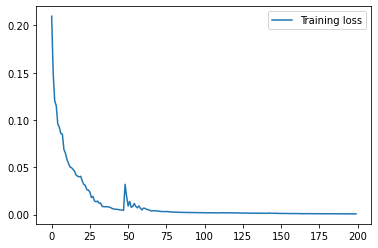

In [310]:
# Train model
#####################
num_epochs = 200
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim = look_back-1
inputTrain = torch.cat((xtrain1, xtrain2, xtrain3, xtrain4, xtrain5), -1)
outputTrain = torch.cat((ytrain2, ytrain3), -1)

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()

    # Forward pass
    ytrainpred = model(inputTrain)

    loss = loss_fn(ytrainpred, outputTrain)
    if t % 10 == 0 and t != 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


Train Score: 0.00 RMSE
Test Score: 0.00 RMSE


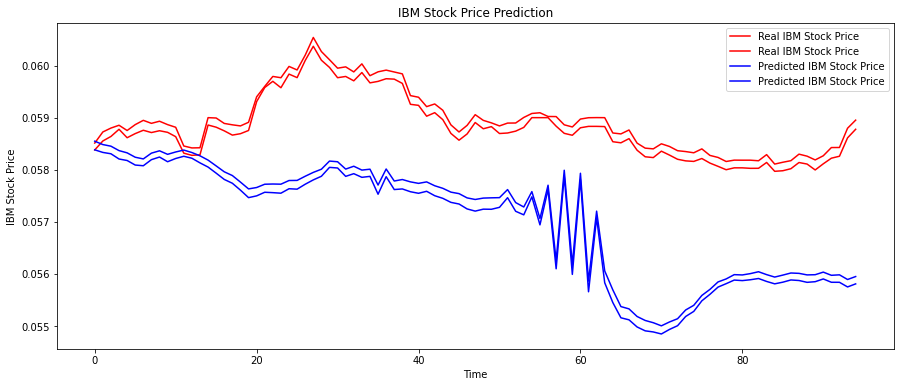

In [311]:
inputTest = torch.cat((xtest1, xtest2, xtest3, xtest4, xtest5), -1)
outputTest = torch.cat((ytest2, ytest3), -1)
# make predictions
model.eval()
ytestpred = model(inputTest).cpu()

# invert predictions
ytrainpred = scaler.inverse_transform(ytrainpred.detach().cpu().numpy())
ytrain = scaler.inverse_transform(outputTrain.detach().cpu().numpy())
ytestpred = scaler.inverse_transform(ytestpred.detach().cpu().numpy())
ytest = scaler.inverse_transform(outputTest.detach().cpu().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(ytrain[:, 0], ytrainpred[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(ytest[:, 0], ytestpred[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))

axes.plot(ytest, color='red', label='Real IBM Stock Price')
axes.plot(ytestpred, color='blue', label='Predicted IBM Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()

In [312]:
print(len(ytestpred[0]))

2


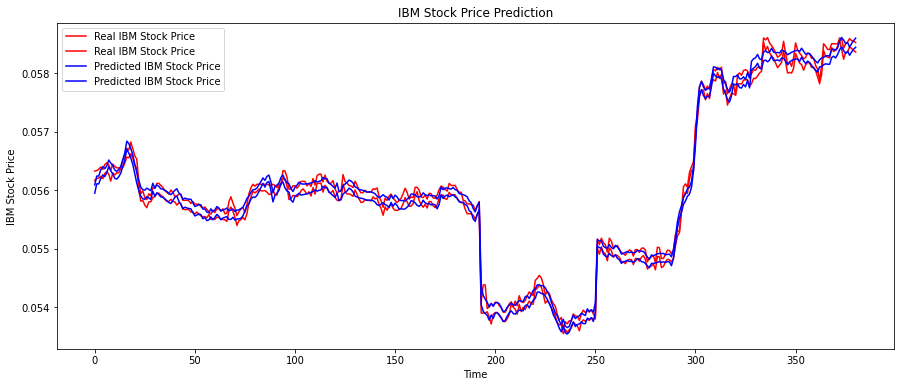

In [313]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))

axes.plot(ytrain, color = 'red', label = 'Real IBM Stock Price')
axes.plot(ytrainpred, color = 'blue', label = 'Predicted IBM Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()